In [29]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from collections import Counter
import itertools
import seaborn as sn

pd.set_option('display.max_colwidth', 180)
pd.set_option('expand_frame_repr', False)

In [2]:
csvfile = '../proc_data_phase0/verification/all_responses_round0-3_verified_new.csv'
df = pd.read_csv(csvfile, 
    sep="\t")

total_objects=len(df)
print("Total objects: ", total_objects)
df.columns

Total objects:  25315


Index(['vg_image_id', 'cat', 'synset', 'vg_obj_name', 'responses_r0',
       'opt-outs', 'vg_domain', 'top_response_domain_r0',
       'responses_domains_r0', 'url', 'sample_type', 'responses_domains_r1',
       'responses_r1', 'top_response_domain_r1', 'responses_domains_r2',
       'responses_r2', 'top_response_domain_r2', 'responses_domains_r3',
       'responses_r3', 'top_response_domain_r3', 'vg_object_id',
       'all_responses', 'clean', 'canon', 'spellchecked', 'spellchecked_min2',
       'adequacy_mean', 'inadequacy_type', 'same_object', 'vg_adequacy_mean',
       'vg_inadequacy_type', 'vg_same_object'],
      dtype='object')

In [3]:
df

,vg_image_id,cat,synset,vg_obj_name,responses_r0,opt-outs,vg_domain,top_response_domain_r0,responses_domains_r0,url,...,clean,canon,spellchecked,spellchecked_min2,adequacy_mean,inadequacy_type,same_object,vg_adequacy_mean,vg_inadequacy_type,vg_same_object
0,2357077,person,athlete.n.01,batter,"{'man': 4, 'batter': 2, 'baseball player': 1, 'player': 1, 'person': 1}",{},people,people,"{'people': 0.889, '$baseball player': 0.111}",http://object-naming-amore.upf.edu//2357077_815223_singleton_obj.png,...,"Counter({'man': 11, 'batter': 8, 'player': 5, 'person': 4, 'baseball player': 2, 'helmet': 2, 'boy': 1, 'uniform': 1, 'bat': 1})","Counter({'man': 11, 'batter': 8, 'player': 5, 'person': 4, 'baseball player': 2, 'helmet': 2, 'boy': 1, 'uniform': 1, 'bat': 1})","Counter({'man': 11, 'batter': 8, 'player': 5, 'person': 4, 'baseball player': 2, 'helmet': 2, 'boy': 1, 'uniform': 1, 'bat': 1})","Counter({'man': 11, 'batter': 8, 'player': 5, 'person': 4, 'baseball player': 2, 'helmet': 2})","{'man': 1.0, 'person': 1.0, 'helmet': 0.5, 'baseball player': 1.0, 'player': 1.0, 'batter': 1.0}","{'man': {nan: 1.0}, 'person': {nan: 1.0}, 'helmet': {'bounding box': 1.0}, 'baseball player': {nan: 1.0}, 'player': {nan: 1.0}, 'batter': {nan: 1.0}}","{'man': {'man': 1.0, 'person': 1.0, 'batter': 1.0, 'player': 1.0, 'helmet': 0.0, 'baseball player': 1.0}, 'person': {'man': 1.0, 'person': 1.0, 'batter': 1.0, 'player': 1.0, 'h...",1.00,{nan: 1.0},"{'man': 1.0, 'person': 1.0, 'batter': 1.0, 'player': 1.0, 'helmet': 0.0, 'baseball player': 1.0}"
1,2378759,article of clothing,overgarment.n.01,jacket,"{'jacket': 3, 'sweatshirt': 2, 'man': 2, 'hoodie': 1, 'person': 1}",{},clothing,clothing,"{'clothing': 0.333, '$sweatshirt': 0.222, 'people': 0.333, '$hoodie': 0.111}",http://object-naming-amore.upf.edu//2378759_1365136_supercat_unique.png,...,"Counter({'jacket': 14, 'man': 11, 'sweatshirt': 4, 'hoodie': 4, 'person': 2, 'shirt': 1})","Counter({'jacket': 14, 'man': 11, 'sweatshirt': 4, 'hoodie': 4, 'person': 2, 'shirt': 1})","Counter({'jacket': 14, 'man': 11, 'sweatshirt': 4, 'hoodie': 4, 'person': 2, 'shirt': 1})","Counter({'jacket': 14, 'man': 11, 'sweatshirt': 4, 'hoodie': 4, 'person': 2})","{'man': 0.5, 'person': 0.5, 'sweatshirt': 1.0, 'jacket': 1.0, 'hoodie': 1.0}","{'man': {'bounding box': 1.0}, 'person': {'bounding box': 1.0}, 'sweatshirt': {nan: 1.0}, 'jacket': {nan: 1.0}, 'hoodie': {nan: 1.0}}","{'man': {'hoodie': 0.0, 'man': 1.0, 'sweatshirt': 0.0, 'person': 1.0, 'jacket': 0.0}, 'person': {'hoodie': 0.0, 'man': 1.0, 'sweatshirt': 0.0, 'person': 1.0, 'jacket': 0.0}, 's...",1.00,{nan: 1.0},"{'hoodie': 1.0, 'man': 0.0, 'sweatshirt': 1.0, 'person': 0.0, 'jacket': 1.0}"
2,2319953,animal,ungulate.n.01,giraffe,{'giraffe': 7},{'#bbox': 2},animals_plants,animals_plants,{'animals_plants': 1.0},http://object-naming-amore.upf.edu//2319953_3089834_singleton_obj.png,...,"Counter({'giraffe': 32, 'woman': 1})","Counter({'giraffe': 32, 'woman': 1})","Counter({'giraffe': 32, 'woman': 1})",Counter({'giraffe': 32}),{'giraffe': 1.0},{'giraffe': {nan: 1.0}},{'giraffe': {'giraffe': 1.0}},1.00,{nan: 1.0},{'giraffe': 1.0}
3,2361401,animal,ungulate.n.01,giraffe,{'giraffe': 9},{},animals_plants,animals_plants,{'animals_plants': 1.0},http://object-naming-amore.upf.edu//2361401_2363103_singleton_obj.png,...,Counter({'giraffe': 36}),Counter({'giraffe': 36}),Counter({'giraffe': 36}),Counter({'giraffe': 36}),{'giraffe': 1.0},{'giraffe': {nan: 1.0}},{'giraffe': {'giraffe': 1.0}},1.00,{nan: 1.0},{'giraffe': 1.0}
4,2401994,"food, nutrient",dish.n.02,sandwich,"{'sandwich': 6, 'food': 2, 'hotdog': 1}",{},food,food,"{'food': 0.889, '$hotdog': 0.111}",http://object-naming-amore.upf.edu//2401994_1141828_singleton_obj.png,...,"Counter({'sandwich': 25, 'food': 6, 'hotdog': 1, 'sandwhich': 1, 'foot': 1, 'cake': 1, 'burger': 1})","Counter({'sandwich': 26, 'food': 7, 'hotdog': 1, 'cake': 1, 'burger': 1})","Counter({'sandwich': 26, 'food': 7, 'hotdog': 1, 'cake': 1, 'burger': 1})","Counter({'sand

In [7]:
df.iloc[25313]

vg_image_id                                                                                                                                                                                           2380161
cat                                                                                                                                                                                   structure, construction
synset                                                                                                                                                                                             house.n.01
vg_obj_name                                                                                                                                                                                            castle
responses_r0                                                                                                                                              {'building': 6, 'fort'

In [47]:
def map_score(s):
    if s == 1:
        return 3
    if s == 0:
        return 0
    elif s < 0.5:
        return 1
    else:
        return 2

In [128]:
adeq_hist = []
same_hist = []
error_hist = Counter()
adeq2same = np.zeros((2,2))
adeq2same2 = np.zeros((4,4))

nan = "none"

for ix,row in df.iterrows():
    resp = eval(row.spellchecked_min2)
    top = resp.most_common(1)[0][0]
    adeq = eval(row.adequacy_mean)
    adeq = {k:v for (k,v) in adeq.items() if not k == top}
    same = eval(row.same_object)[top]
    same = {k:v for (k,v) in same.items() if not k == top}
    #print(row.inadequacy_type)
    error = eval(row.inadequacy_type)
    for n in adeq:
        if n != top:
            if adeq[n] > 0.5 and same[n] > 0.5:
                adeq2same[1][1] += 1
            elif adeq[n] <= 0.5 and same[n] > 0.5:
                adeq2same[0][1] += 1
                #print(row.vg_image_id,"  n_1:",top)
                #print("          n_hat:",n,"(AD:",adeq[n], ") (SO:",same[n],")")
                #print()

            elif adeq[n] <= 0.5 and same[n] <= 0.5:
                adeq2same[0][0] += 1
            else:
                adeq2same[1][0] += 1
                #print(row.vg_image_id,"  n_1:",top)
                #print("          n_hat:",n,"(AD:",adeq[n], ") (SO:",same[n],")")
                
            s1 = map_score(adeq[n])
            s2 = map_score(same[n])
            #print(s1,s2)
            adeq2same2[s1][s2] += 1
            
            if adeq[n] != 1.0:
                error_hist["/".join(sorted(error[n].keys()))] += 1
            
                
    adeq_hist += list(adeq.values())
    same_hist += list(same.values())

In [19]:
adeq_hist;

In [111]:
adeq2same[1][0]

2492.0

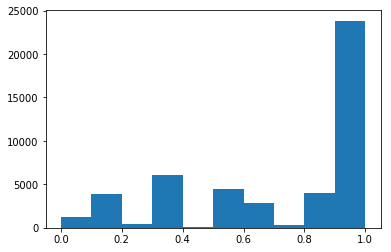

In [24]:
plt.hist(adeq_hist)
plt.savefig("adequacy_histogram.jpg")

In [23]:
plt.savefig("adequacy_histogram.jpg")

<Figure size 432x288 with 0 Axes>

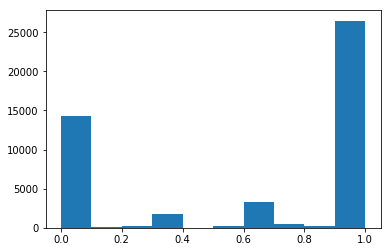

In [25]:
plt.hist(same_hist)
plt.savefig("same_object_histogram.jpg")

In [155]:
t= sum(error_hist.values())
err1 = Counter({k:(v/t)*100 for (k,v) in error_hist.items() if not "/" in k})
err2 = Counter({k:(v/t)*100 for (k,v) in error_hist.items() if "/" in k})
err_df = pd.DataFrame(list(err1.items())+err2.most_common(8),columns=['error','%'])


In [156]:
err_df.round(1)

,error,%
0,bounding box,46.9
1,visual,2.5
2,other,0.6
3,linguistic,0.2
4,bounding box/none,18.4
5,none/visual,16.8
6,bounding box/visual,3.0
7,bounding box/none/visual,1.9
8,bounding box/other,1.8
9,none/other,1.4


In [157]:
print(err_df.round(1).to_latex(index=False))

\begin{tabular}{lr}
\toprule
                    error &     \% \\
\midrule
             bounding box &  46.9 \\
                   visual &   2.5 \\
                    other &   0.6 \\
               linguistic &   0.2 \\
        bounding box/none &  18.4 \\
              none/visual &  16.8 \\
      bounding box/visual &   3.0 \\
 bounding box/none/visual &   1.9 \\
       bounding box/other &   1.8 \\
               none/other &   1.4 \\
          linguistic/none &   1.3 \\
             other/visual &   1.2 \\
\bottomrule
\end{tabular}



In [28]:
adeq2same

{0: {0: 14138, 1: 2011}, 1: {0: 2492, 1: 28520}}

In [36]:
adeq2same/adeq2same.sum()

array([[0.2997816 , 0.04264117],
       [0.05284027, 0.60473696]])

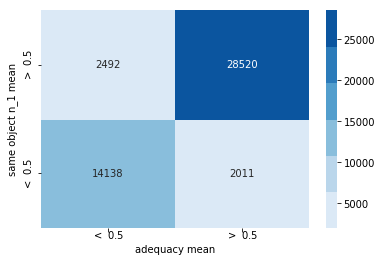

In [68]:
res = sn.heatmap(adeq2same, annot=True, fmt='.0f',cmap=sn.color_palette("Blues"))
res.invert_yaxis()
plt.yticks([0.5,1.5], ['$<$ 0.5', '$>$ 0.5'],va='center')
plt.xticks([0.5,1.5], ['$<$ 0.5', '$>$ 0.5'],va='center')
plt.xlabel('adequacy mean')
plt.ylabel('same object n_1 mean')
plt.savefig("contingency_table.jpg")

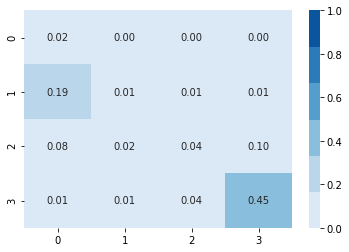

In [54]:
res = sn.heatmap(adeq2same2/adeq2same2.sum(), annot=True, vmin=0.0, vmax=1.0, fmt='.2f', cmap=sn.color_palette("Blues"))

In [51]:
adeq2same2.sum()

47161.0

In [52]:
adeq2same.sum()

47161.0

In [69]:
import spacy

ModuleNotFoundError: No module named 'spacy'

In [95]:
same_obj = np.array(same_hist) == 0
adeq_same_obj = np.array(adeq_hist)[same_obj]

In [96]:
len(adeq_same_obj)

14338

In [97]:
len(adeq_hist)

47161

(array([ 669., 2140.,  187., 3323.,   51., 1970.,  765.,   70.,  803.,
        4360.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

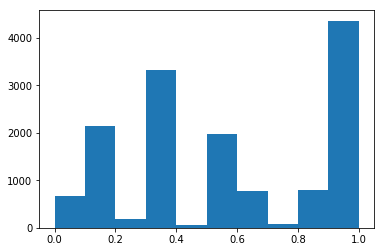

In [98]:
plt.hist(adeq_same_obj)

(array([6.370e+03, 1.400e+01, 4.100e+01, 4.470e+02, 3.000e+00, 4.500e+01,
        6.560e+02, 8.100e+01, 3.700e+01, 4.053e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

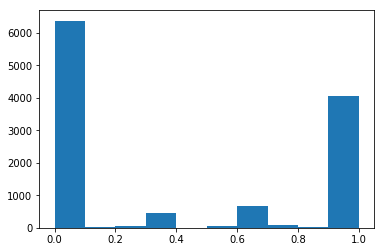

In [101]:
inadeq_obj = np.array(adeq_hist) < 0.5
same_inadeq_obj = np.array(same_hist)[inadeq_obj]
plt.hist(same_inadeq_obj)